## Model interpretowalny i jego analiza

*Disclaimer*: Definicje niektórych funkcji do pipeline i ich opis powtarza się w pliku z XGBoost.

In [1]:
import pandas as pd
import numpy as np
import joblib
import shap
from scipy.stats import pearsonr



from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, average_precision_score, brier_score_loss, log_loss, precision_score, recall_score, f1_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold



from scipy.stats import ks_2samp
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.inspection import PartialDependenceDisplay

from sklearn.calibration import calibration_curve
from scipy.special import logit, expit
from sklearn.calibration import CalibratedClassifierCV
from betacal import BetaCalibration
from statsmodels.stats.proportion import proportion_confint

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

---
## `One Hot Encoding`
---

Wczytano dane z pliku `zbiór_10.csv`, gdzie zmienną celu była kolumna `default`. Niepotrzebna kolumna `szczegolnaFormaPrawna_Symbol`, zawierająca tę samą wartość dla wszystkich obserwacji, została usunięta. Następnie przygotowano kolumny kategoryczne (`formaWlasnosci_Symbol`, `schemat_wsk_bilans`, `schemat_wsk_rzis`) do użycia w modelu regresji liniowej poprzez One-Hot Encoding. Dla każdej kolumny kategorycznej utworzono odpowiadające jej kolumny binarne, reprezentujące wszystkie możliwe kategorie, a oryginalne kolumny kategoryczne usunięto. Otrzymany zbiór danych podlega później dalszym transformacjom.

In [2]:
data = pd.read_csv("zbiór_10.csv")

# dropujemy szczegolna forma wlasnosci (kazdy ma taka sama 117)
data = data.drop(columns="szczegolnaFormaPrawna_Symbol")

X = data.drop(columns=["default"])
y = data["default"]


categorical_cols = [
    "formaWlasnosci_Symbol",
    "schemat_wsk_bilans",
    "schemat_wsk_rzis"
]

ohe = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False),
         categorical_cols)
    ],
    remainder="passthrough"
)

---
## `PKDKodWoEEncoder` (Weight of Evidence Encoder)

Klasa transformująca zmienną kategoryczną 'pkdKod' na miarę Weight of Evidence (WoE). Służy do przygotowania zmiennych kategorycznych o dużej liczbie unikalnych wartości dla modeli scoringowych.

---

### **Działanie Kluczowe**
* Grupowanie Rzadkich Kategorii: Identyfikuje top_n najczęściej występujących kategorii. Wszystkie pozostałe kategorie (rzadkie) są grupowane w jedną kategorię oznaczoną jako '0'.

* Obliczanie WoE: Dla każdej z topowych kategorii i kategorii '0' oblicza WoE. WoE jest logarytmem naturalnym z ilorazu szans (Good/Bad) w danej grupie, podzielonego przez iloraz szans w całej próbie (Good_Total/Bad_Total).

$$WoE = \ln \left( \frac{P(\text{Good} | \text{Grupa})}{P(\text{Bad} | \text{Grupa})} / \frac{P(\text{Good Total})}{P(\text{Bad Total})} \right)$$

* Wygładzanie (Smoothing): Dodaje wartość smoothing (np. 0.5) do liczebności zdarzeń "Good" i "Bad" (dobrych i złych), aby uniknąć dzielenia przez zero i zmniejszyć wpływ małych prób.

* Transformacja: Zastępuje wartość pkdKod obliczoną wartością WoE. Oryginalna kolumna pkdKod jest usuwana.

In [3]:
class PKDKodWoEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, top_n=10, smoothing=0.5):
        self.top_n = top_n
        self.smoothing = smoothing
    
    def fit(self, X, y):
        X = X.copy()
        y = y.copy()

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=[f"col_{i}" for i in range(X.shape[1])])
        
        # wybieramy top_n najczęstszych kategorii

        self.top_values_ = X['pkdKod'].value_counts().nlargest(self.top_n).index
        
        # kolumna w ktorej rzadkie wartosci zamieniamy na '0'
        grouped = X['pkdKod'].where(X['pkdKod'].isin(self.top_values_), other='0')
        
        # liczymy woe
        df = pd.DataFrame({'group': grouped, 'target': y})
        agg = df.groupby('group')['target'].agg(['sum', 'count'])
        agg = agg.rename(columns={'sum':'bad', 'count':'total'})
        agg['good'] = agg['total'] - agg['bad']

        agg['bad_s'] = agg['bad'] + self.smoothing
        agg['good_s'] = agg['good'] + self.smoothing

        total_bad = agg['bad_s'].sum()
        total_good = agg['good_s'].sum()

        agg['woe'] = np.log((agg['good_s'] / total_good) / (agg['bad_s'] / total_bad))

        self.woe_map_ = agg['woe'].to_dict()
        self.fallback_ = np.mean(list(self.woe_map_.values()))
        
        return self
    
    def transform(self, X):
        X = X.copy()
        grouped = X['pkdKod'].where(X['pkdKod'].isin(self.top_values_), other='0')
        X['WoE_pkdKod_grouped'] = grouped.map(self.woe_map_).fillna(self.fallback_)
        return X.drop(columns=['pkdKod'])
    
    # blagam zeby to naprawilo shap
    def get_feature_names_out(self, input_features=None):
        """
        Zwraca nazwy kolumn po transformacji.
        Jeśli wejściowa kolumna 'pkdKod' została zastąpiona przez 'WoE_pkdKod_grouped',
        zwróć nową nazwę wraz z pozostałymi kolumnami.
        """
        if input_features is None:
            return np.array(['WoE_pkdKod_grouped'])
        
        new_features = []
        for feat in input_features:
            if feat == 'pkdKod':
                new_features.append('WoE_pkdKod_grouped')
            else:
                new_features.append(feat)
        return np.array(new_features)

---
## `MissingValueIndicatorAndImputer`

Ta klasa jest transformatorem scikit-learn, który realizuje dwie operacje jednocześnie na kolumnach numerycznych: imputację brakujących wartości oraz tworzenie kolumn-wskaźników braków danych.

---

### **Działanie Kluczowe**

* Obsługa Nieskończoności: Zamienia wartości nieskończone (np.inf, -np.inf) na braki danych (np.nan).
* Imputacja: Wykorzystuje SimpleImputer (strategia domyślna to mediana, ale można zmienić np. na mean lub most_frequent) do zastąpienia brakujących wartości. W fazie fit uczy się wartości imputacji, a w transform je stosuje.

* Wskaźnik Braków Danych: Tworzy nową kolumnę dla każdej oryginalnej kolumny, której nazwa kończy się na _mial_braki_danych. Wartość w tej kolumnie wynosi 1, jeśli oryginalna kolumna miała brak danych, i 0 w przeciwnym razie.

* Łączenie: Zwraca ramkę danych zawierającą zaimputowane oryginalne kolumny oraz nowo utworzone kolumny-wskaźniki.

In [4]:
class MissingValueIndicatorAndImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy="median"):
        self.strategy = strategy

    def fit(self, X, y=None):
        X = X.replace([np.inf, -np.inf], np.nan).copy()
        self.base_cols_ = list(X.columns)

        # kolumny do imputacji
        self.imputer_ = SimpleImputer(strategy=self.strategy)
        self.imputer_.fit(X[self.base_cols_])

        # nazwy kolumn wskaźników
        self.indicator_cols_ = [f"{c}_mial_braki_danych" for c in self.base_cols_]

        return self

    def transform(self, X):
        X = X.replace([np.inf, -np.inf], np.nan).copy()

        # imputacja
        X_imputed = pd.DataFrame(
            self.imputer_.transform(X[self.base_cols_]),
            columns=self.base_cols_,
            index=X.index
        )

        # wskaźniki braków danych
        indicator_df = X[self.base_cols_].isna().astype(int)
        indicator_df.columns = self.indicator_cols_
        indicator_df.index = X.index

        # łączymy razem
        X_out = pd.concat([X_imputed, indicator_df], axis=1)

        return X_out
    
    def get_feature_names_out(self, input_features=None):
        """
        Zwraca nazwy kolumn po imputacji i dodaniu wskaźników braków danych.
        """
        if input_features is None:
            input_features = self.base_cols_

        # po transformacji mamy oryginalne kolumny + kolumny wskaźników
        return np.array(list(input_features) + [f"{c}_mial_braki_danych" for c in input_features])

---
## `DropConstantColumns` (Usuwanie stałych kolumn)

Prosty transformator, którego zadaniem jest identyfikacja i usunięcie z ramki danych kolumn, które mają **jedną lub zero unikalnych wartości** (są stałe).

---

### **Działanie Kluczowe**

* Fit: W fazie treningu (fit) identyfikuje kolumny, w których liczba unikalnych wartości (nunique()) jest mniejsza lub równa 1. Nazwy tych kolumn są przechowywane w self.cols_to_drop_.
* Transform: W fazie transformacji (transform) usuwa te zidentyfikowane kolumny z ramki danych.

In [5]:
class DropConstantColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.cols_to_drop_ = [col for col in X.columns if X[col].nunique() <= 1]
        return self

    def transform(self, X):
        return X.drop(columns=self.cols_to_drop_, errors='ignore')
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.array([] if not hasattr(self, "cols_to_drop_") else [
                col for col in X.columns if col not in self.cols_to_drop_
            ])

        return np.array([col for col in input_features if col not in getattr(self, "cols_to_drop_", [])])

## `CorrelationBasedFeatureSelector`

Ta klasa jest transformatorem scikit-learn służącym do **wykrywania i usuwania silnie skorelowanych cech** w celu redukcji współliniowości oraz poprawy stabilności i interpretowalności modelu regresji liniowej.

---

### **Działanie kluczowe**

* Tworzona jest macierz korelacji pomiędzy wszystkimi cechami numerycznymi.  

*  Dla każdej pary cech, których korelacja przekracza wartość progową, rozpoczyna się proces decyzyjny dotyczący usunięcia jednej z nich.
   - Dla każdej silnie skorelowanej pary obliczana jest bezwzględna korelacja obu cech z wartością docelową (`y`).  
   - Usuwana jest ta cecha, która wykazuje słabszą relację z targetem, co pozwala zachować bardziej informatywną zmienną.

* Zidentyfikowane cechy są zapisywane w atrybucie `to_drop_` i usuwane podczas transformacji danych.

* Transformacja: usuwa z przekazanej ramki danych wszystkie kolumny znajdujące się na liście `to_drop_`, pozostawiając jedynie cechy spełniające kryteria niskiej współkorelacji.

In [6]:
class CorrelationBasedFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold

    def fit(self, X, y):

        # If DataFrame → keep names
        if isinstance(X, pd.DataFrame):
            self.feature_names_ = X.columns.tolist()
        else:
            # If numpy → invent names
            self.feature_names_ = [f"f{i}" for i in range(X.shape[1])]
            X = pd.DataFrame(X, columns=self.feature_names_)

        y = pd.Series(y)

        corr_matrix = X.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

        to_drop = []

        for col_a in upper.columns:
            highly_corr = upper.index[upper[col_a] > self.threshold].tolist()

            for col_b in highly_corr:

                if col_a not in to_drop and col_b not in to_drop:

                    corr_a = abs(np.corrcoef(X[col_a], y)[0, 1])
                    corr_b = abs(np.corrcoef(X[col_b], y)[0, 1])

                    if corr_a < corr_b:
                        to_drop.append(col_a)
                    else:
                        to_drop.append(col_b)

        self.to_drop_ = to_drop
        return self

    def transform(self, X):

        # Convert to DataFrame to drop by names
        if isinstance(X, pd.DataFrame):
            X_df = X.copy()
            X_df.columns = self.feature_names_
        else:
            # numpy array → wrap into DataFrame with stored names
            X_df = pd.DataFrame(X, columns=self.feature_names_)

        # Drop selected columns
        X_df = X_df.drop(columns=self.to_drop_, errors='ignore')

        # Return NUMPY array (sklearn standard)
        return X_df.values

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_

        return np.array([
            col for col in input_features
            if col not in getattr(self, "to_drop_", [])
        ])


## `CustomCorrelationTransformer`


Ten transformer scikit-learn służy do automatycznego odwracania znaku cech, które wykazują ujemną korelację z wartością docelową (`y`).  
Celem jest ujednolicenie kierunku zależności wszystkich cech względem targetu, co ułatwia interpretację cech.

---

### **Działanie kluczowe**

- W metodzie `fit` obliczana jest korelacja Pearsona pomiędzy każdą cechą a zmienną docelową `y`.
- Jeżeli dana cecha ma **ujemny** współczynnik korelacji, jej nazwa trafia do listy `columns_to_flip`.
- Lista ta jest przechowywana wewnątrz transformera i wykorzystywana podczas przekształcania danych.


### **Transformacja danych**

- W metodzie `transform` wszystkie kolumny znajdujące się na liście `columns_to_flip` są przemnażane przez `-1`.
- Kolumny o korelacji dodatniej nie są modyfikowane.


In [7]:
class CustomCorrelationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns_to_flip = []
        self.feature_names_ = None
    
    def fit(self, X, y=None):
        if isinstance(y, pd.DataFrame):
            y = y.iloc[:, 0]

        if isinstance(X, np.ndarray):
            self.feature_names_ = [f"col_{i}" for i in range(X.shape[1])]
            X_df = pd.DataFrame(X, columns=self.feature_names_)
        else:
            self.feature_names_ = list(X.columns)
            X_df = X

        self.columns_to_flip = []

        for col in self.feature_names_:
            try:
                corr, _ = pearsonr(X_df[col], y)
                if corr < 0:
                    self.columns_to_flip.append(col)
            except Exception:
                pass

        return self
    
    def transform(self, X):
        if isinstance(X, np.ndarray):
            X_df = pd.DataFrame(X, columns=self.feature_names_)
        else:
            X_df = X.copy()

        # Odwracamy ujemne cechy
        for col in self.columns_to_flip:
            if col in X_df.columns:
                X_df[col] = -1 * X_df[col]

        return X_df.values
    
    def get_feature_names_out(self, input_features=None):
        # Zwracamy nazwy takie same jak wejściowe
        return np.array(self.feature_names_)


## `Podział Danych` na zbiór treningowy i testowy


Treningowy (Train): Używany do uczenia modelu.

Testowy (Test): Używany do ostatecznej, niezależnej oceny wydajności gotowego modelu.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2137, stratify = y)

## `Pipeline modelu i dopasowanie klasyfikatora`

* Budowa pipeline  
   - Pipeline składa się z kolejnych kroków przetwarzania danych zdefiniowanych wcześniej i dopasowania modelu:  
     - `PKDKodWoEEncoder(top_n=10, smoothing=0.5)` – kodowanie zmiennej PKD metodą WOE, uwzględniające 10 najważniejszych kategorii
     - `MissingValueIndicatorAndImputer(strategy="median")` – wypełnienie braków danych oraz tworzenie kolumn wskaźnikowych dla braków
     - `DropConstantColumns()` – usuwanie kolumn o stałej wartości
     - `CorrelationBasedFeatureSelector(threshold=0.8)` – usuwanie cech silnie skorelowanych między sobą.  
     - `StandardScaler()` – skalowanie zmiennych
     - `LogisticRegression(...)` – klasyfikator regresji logistycznej

* Definicja siatki parametrów (`param_grid`) 
   - `classifier__C`: poziomy siły regularyzacji [0.001, 0.01, 0.1, 1, 10, 100] 
   - `classifier__penalty`: L1 lub L2
   - `classifier__class_weight`: opcje zrównoważenia klas lub jego brak [None, "balanced", {0: 1, 1: 3}, {0: 1, 1: 5}]

* Walidacja krzyżowa  
   - Użyto `StratifiedKFold` z 5 podziałami i mieszaniem danych 

* Dopasowanie hiperparametów
   - Do przeszukania siatki parametrów zastosowano `GridSearchCV` z użyciem metryki `roc_auc` 
   
* Efekt końcowy
   - Pipeline został dopasowany do danych treningowych (`X_train`, `y_train`) i wybrano najlepszy model na podstawie średniego ROC AUC z walidacji krzyżowej.

In [9]:
# OHE do X_train
X_train_transformed = ohe.fit_transform(X_train)

X_test_transformed = ohe.transform(X_test)

ohe_feature_names = ohe.get_feature_names_out()

X_train_ohe = pd.DataFrame(X_train_transformed, columns=ohe_feature_names, index=X_train.index)
X_test_ohe = pd.DataFrame(X_test_transformed, columns=ohe_feature_names, index=X_test.index)

X_train_ohe.columns = [col.replace("cat__", "").replace("remainder__", "") for col in X_train_ohe.columns]
X_test_ohe.columns = [col.replace("cat__", "").replace("remainder__", "") for col in X_test_ohe.columns]

X_train = X_train_ohe.copy()
X_test = X_test_ohe.copy()


In [10]:
# pipeline = Pipeline([
#     ("pkd_woe", PKDKodWoEEncoder(top_n=10, smoothing=0.5)),
#     ("missing", MissingValueIndicatorAndImputer(strategy="median")),
#     ("drop_constant", DropConstantColumns()),
#     ("corr_selector", CorrelationBasedFeatureSelector(threshold=0.8)),
#     ("scaler", StandardScaler()),
#     ("classifier", LogisticRegression(
#         random_state=42,
#         class_weight="balanced",
#         max_iter=1000,
#         solver='liblinear'
#     ))
# ])


# param_grid = {
#     "classifier__C": [0.001, 0.01, 0.1, 1, 10, 100],  # siła regularyzacji
#     "classifier__penalty": ["l1", "l2"],  # L1 dla selekcji cech, L2 dla stabilności
#     "classifier__class_weight": [None, "balanced", {0: 1, 1: 3}, {0: 1, 1: 5}]
# }

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)

# grid.fit(X_train, y_train)

## `Poprawiony pipeline uwzględniający wpływ zmiennych`

Pipeline składa się z tych samych elementów co poprzedni, ale usunięte zostało balansowanie klas oraz została dodana transformacja, dzięki której wszystkie zmienne wchodzą w jednym kierunku.


In [11]:
# finalny pipeline z lepszymi parametrami

# best_model = Pipeline([
#     ("pkd_woe", PKDKodWoEEncoder(top_n=10, smoothing=0.5)),
#     ("missing", MissingValueIndicatorAndImputer(strategy="median")),
#     ("drop_constant", DropConstantColumns()),
#     ("corr_selector", CorrelationBasedFeatureSelector(threshold=0.8)),
#     ("scaler", StandardScaler()),
#     ("corr_transformer", CustomCorrelationTransformer()),
#     ("classifier", LogisticRegression(
#         random_state=42,
#         solver='liblinear',  
#         C= 2,
#         penalty='l2',        
#         max_iter=1000
#     ))
# ])

# joblib.dump(best_model, "best_regression_model.pkl")

In [12]:
best_model = joblib.load('best_regression_model.pkl')

best_model.fit(X_train, y_train)

Pipeline(steps=[('pkd_woe', PKDKodWoEEncoder()),
                ('missing', MissingValueIndicatorAndImputer()),
                ('drop_constant', DropConstantColumns()),
                ('corr_selector',
                 CorrelationBasedFeatureSelector(threshold=0.8)),
                ('scaler', StandardScaler()),
                ('corr_transformer', CustomCorrelationTransformer()),
                ('classifier',
                 LogisticRegression(C=2, max_iter=1000, random_state=42,
                                    solver='liblinear'))])

Funkcja `calculate_ks_score` jest funkcją pomocniczą do obliczania statystyki Kołmogorowa-Smirnowa dla przewidywanych prawdopodobieństw klasyfikatora.

In [13]:
# Statystyka KS - z jakichs przyczyn biblioteki sie buntowaly
def calculate_ks_score(y_true, y_pred_proba):
    scores_0 = y_pred_proba[y_true == 0]
    scores_1 = y_pred_proba[y_true == 1]
    ks_stat, _ = ks_2samp(scores_1, scores_0)
    return ks_stat

In [14]:
## metryki

# Predykcje na zbiorze testowym
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
y_pred = best_model.predict(X_test)
y_train_pred = best_model.predict(X_train)


print("=== OCENA JAKOŚCI MODELU - ZBIÓR TRENINGOWY ===")
print(f"ROC AUC: {roc_auc_score(y_train, y_train_pred_proba):.4f}")
print(f"PR AUC: {average_precision_score(y_train, y_train_pred_proba):.4f}")
print(f"Log Loss: {log_loss(y_train, y_train_pred_proba):.4f}")
print(f"Brier Score: {brier_score_loss(y_train, y_train_pred_proba):.4f}")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred):.4f}")
print(f"F1-Score: {f1_score(y_train, y_train_pred):.4f}")

ks_stat_train = calculate_ks_score(y_train, y_train_pred_proba)
print(f"KS Statistic: {ks_stat_train:.4f}")

print("=== OCENA JAKOŚCI MODELU - ZBIÓR TESTOWY ===")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"PR AUC: {average_precision_score(y_test, y_pred_proba):.4f}")
print(f"Log Loss: {log_loss(y_test, y_pred_proba):.4f}")
print(f"Brier Score: {brier_score_loss(y_test, y_pred_proba):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

ks_stat = calculate_ks_score(y_test, y_pred_proba)
print(f"KS Statistic: {ks_stat:.4f}")

=== OCENA JAKOŚCI MODELU - ZBIÓR TRENINGOWY ===
ROC AUC: 0.8098
PR AUC: 0.3103
Log Loss: 0.1848
Brier Score: 0.0492
Accuracy: 0.9443
Precision: 0.9231
Recall: 0.0938
F1-Score: 0.1702
KS Statistic: 0.4805
=== OCENA JAKOŚCI MODELU - ZBIÓR TESTOWY ===
ROC AUC: 0.6370
PR AUC: 0.0973
Log Loss: 0.4065
Brier Score: 0.0665
Accuracy: 0.9267
Precision: 0.1333
Recall: 0.0364
F1-Score: 0.0571
KS Statistic: 0.2664


# `Interpretacja metryk`

Ocena jakości modelu na zbiorze treningowym pokazuje umiarkowane dopasowanie, z wartością ROC AUC równą 0.8098 oraz KS Statistic 0.4805, co wskazuje na zdolność modelu do rozróżniania klas. Na zbiorze testowym ROC AUC spada do 0.6370, a KS Statistic do 0.2664, co sugeruje pewien poziom przetrenowania modelu.


Wyniki accuracy (0.9443 na treningu, 0.9267 na teście) są wysokie, jednak wynikają głównie z dominującej klasy negatywnej (spłacone kredyty), więc nie odzwierciedlają pełnej skuteczności modelu w przewidywaniu klasy rzadkiej.

(metryki są sporo gorsze niż w modelu przed poprawkami, ale aktualnie celem zmian jest poprawienie interpretowalności)


## `Pobieranie nazw cech i przetworzonych danych po pipeline`

Funkcja `get_feature_names_and_transformed_X` umożliwia uzyskanie listy nazw cech oraz DataFrame po wszystkich transformacjach w pipeline, z wyjątkiem klasyfikatora. Została zaimplementowana przed dodaniem funckji `get_feature_names_out` do własnych elementów pipeline i była jej tymczasowym zamiennikiem.

* Dopasowanie i transformacja
   - Iteruje po wszystkich krokach pipeline’u oprócz klasyfikatora.  
   - Wykonuje dopasowanie i transformację danych dla każdego kroku, jeśli jest to wymagane.

* Obsługa nazw kolumn  
   - Jeśli transformacja zwraca DataFrame, zachowywane są oryginalne nazwy kolumn.  
   - Jeśli zwraca tablicę NumPy, nazwy kolumn generowane są automatycznie lub pobierane z dostępnych atrybutów transformera (`columns_` lub `get_feature_names_out`).

* Wynik końcowy 
   - Zwraca zestaw nazw cech oraz DataFrame po wszystkich transformacjach
   - Funkcja umożliwia również śledzenie liczby cech po każdym kroku przetwarzania, co umożliwia wgląd w proces preprocessingu


In [15]:
# to było zaimplementowanie przed dodaniem get feature names do pipeline, ale dalej jest za duzo kodu zeby juz to usunac 💀💀💀
# Pobieranie nazw cech i nowego X_train po preprocessing
def get_feature_names_and_transformed_X(pipeline, X, y=None):
    """
    Pobiera nazwy cech i zwraca DataFrame po wszystkich transformacjach w pipeline,
    pomijając ostatni krok (klasyfikator).
    
    pipeline: dopasowany sklearn Pipeline
    X: dane wejściowe (DataFrame)
    y: opcjonalnie etykiety (potrzebne dla własnych transformerów)
    
    Zwraca:
    - feature_names: lista nazw cech po transformacjach
    - X_transformed: DataFrame po transformacjach
    """
    X_temp = X.copy()
    
    for step_name, step in list(pipeline.named_steps.items())[:-1]:  # pomijamy classifier
        if hasattr(step, 'fit') and y is not None:
            step.fit(X_temp, y)
        
        # Transformacja
        X_transformed = step.transform(X_temp)
        
        
        if isinstance(X_transformed, pd.DataFrame):
            X_temp = X_transformed
        else:
            # próbujemy wziąć columns_ z transformera
            if hasattr(step, 'columns_'):
                cols = step.columns_
            elif hasattr(step, 'get_feature_names_out'):
                cols = step.get_feature_names_out(X_temp.columns)
            else:
                cols = [f"{step_name}_feature_{i}" for i in range(X_transformed.shape[1])]
            
            X_temp = pd.DataFrame(X_transformed, columns=cols)
        
        print(f"Po kroku '{step_name}': {X_temp.shape[1]} cech")
    
    feature_names = X_temp.columns.tolist()
    
    return feature_names, X_temp



feature_names, X_train_transformed = get_feature_names_and_transformed_X(best_model, X_train, y_train)

Po kroku 'pkd_woe': 238 cech
Po kroku 'missing': 476 cech
Po kroku 'drop_constant': 248 cech
Po kroku 'corr_selector': 135 cech
Po kroku 'scaler': 135 cech
Po kroku 'corr_transformer': 135 cech


## `Analiza współczynników regresji logistycznej`

W tej sekcji przedstawiono interpretację globalną modelu regresji logistycznej poprzez analizę współczynników regresji (log-odds) oraz odpowiadających im ilorazów szans (odds ratios). Celem analizy jest określenie, które cechy modelu mają największy wpływ na przewidywanie klasy pozytywnej.


* Ekstrakcja klasyfikatora  
  - Z wcześniej zbudowanego pipeline’u pobierany jest krok `classifier`, którym jest dopasowana regresja logistyczna. Dzięki temu możliwy jest bezpośredni dostęp do wektora współczynników.

* Obliczenie współczynników i odds ratios
  - `coefficients` – wektor wag modelu (log-odds).  
  - `odds_ratios = exp(coef)` – ile razy rośnie/zmniejsza się szansa pozytywnej klasy przy jednostkowej zmianie danej cechy.

* Tworzenie tabeli ważności cech  
  Powstaje DataFrame zawierający:
  - nazwę cechy,
  - współczynnik,
  - odds ratio,
  - absolutną wartość współczynnika (miara wpływu).

  Następnie dane sortowane są malejąco tak, aby na górze znalazły się cechy o największym znaczeniu.

* Wydruk Top 15 cech
  - Raport wypisuje piętnaście najważniejszych zmiennych, co umożliwia szybką ocenę dominujących czynników ryzyka.

* Wizualizacja współczynników 
  Tworzony jest wykres słupkowy dla 15 najistotniejszych cech. Współczynniki prezentowane są w przestrzeni log-odds.

* Interpretacja

Wysoka wartość współczynnika oznacza silny wpływ zmiennej na wynik modelu
Zmiennie znajdujące się w Top 15 stanowią kluczowe czynniki ryzyka lub bezpieczeństwa.


=== INTERPRETACJA GLOBALNA ===
Top 15 najważniejszych cech:
                                        feature  coefficient  odds_ratio  \
122                       wsk_struktura_majatku     1.387907    4.006456   
36                             Srodki_pieniezne     1.375237    3.956012   
131            RP_amortyzacja_mial_braki_danych     1.304407    3.685505   
62                        wsk_kapital_do_aktywa     1.218933    3.383576   
25                    Naleznosci_dlugoterminowe     1.115724    3.051777   
79                           wsk_mnoznik_kap_wl     0.955524    2.600033   
83                                 wsk_ebitda_2     0.913907    2.494048   
68                                      dotacje     0.900822    2.461626   
110         wsk_rotacja_zobowiazan_dostaw_uslug     0.894113    2.445165   
55   Zobowiazania_dostaw_uslug_pow12m_pozostale     0.885510    2.424221   
120                      wsk_zysk_CF_operacyjny     0.872377    2.392592   
97             wsk_ogolnego

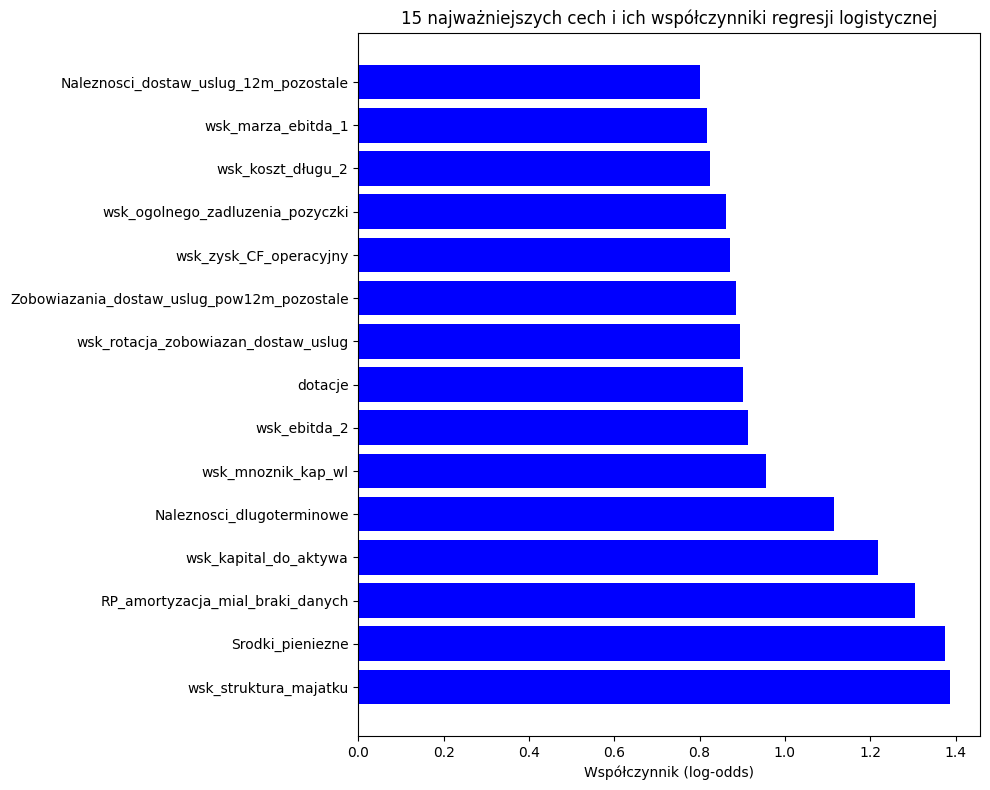

In [16]:
# Analiza współczynników

# wyciagamy klasyfikator z pipeline
classifier = best_model.named_steps['classifier']
coefficients = classifier.coef_[0]
odds_ratios = np.exp(coefficients)

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'odds_ratio': odds_ratios,
    'abs_importance': np.abs(coefficients)
}).sort_values('abs_importance', ascending=False)

print("\n=== INTERPRETACJA GLOBALNA ===")
print("Top 15 najważniejszych cech:")
print(feature_importance_df.head(15))

# Wizualizacja współczynników
plt.figure(figsize=(10, 8))
top_features = feature_importance_df.head(15)
colors = ['red' if coef < 0 else 'blue' for coef in top_features['coefficient']]
plt.barh(top_features['feature'], top_features['coefficient'], color=colors)
plt.xlabel('Współczynnik (log-odds)')
plt.title('15 najważniejszych cech i ich współczynniki regresji logistycznej')
plt.tight_layout()
plt.show()

## `PartialDependenceDisplay` dla wybranych cech

Ten fragment kodu generuje wykresy ICE (niebieskie) i PDP (żółte) dla wybranych cech modelu.

---

### `Działanie kluczowe`

- Dla każdej cechy (`Kapital_wlasny`, `wsk_zadluzenia_pozyczki_dlugie`, `Naleznosci_dlugoterminowe`) wyświetlany jest wykres zależności częściowej (PDP) wraz z wykresem indywidualnych efektów (ICE).  
- Dla niektórych cech stosowane są percentyle `(0.01, 0.99)`, aby uniknąć problemów z wartościami odstającymi.  
- Wykresy ułatwiają interpretację wpływu poszczególnych cech na predykcję modelu.

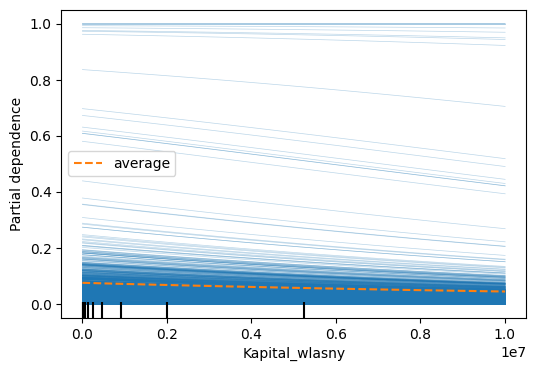

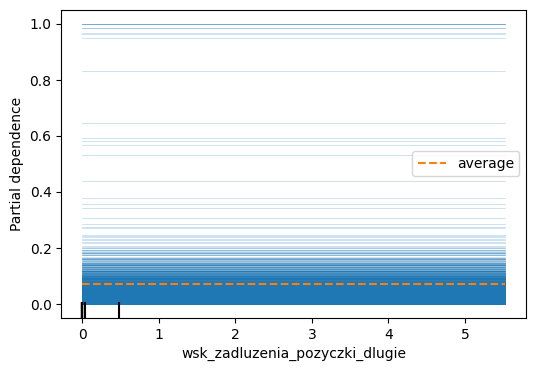

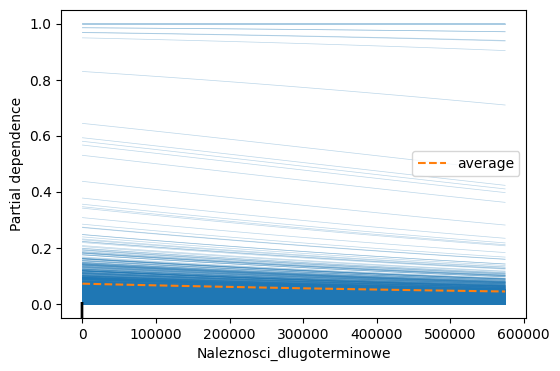

In [17]:
# ICE (niebieskie) i PDP (żółte)

import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")

fig, ax = plt.subplots(figsize=(6, 4))
disp = PartialDependenceDisplay.from_estimator(
    best_model,
    X_test,
    features=['Kapital_wlasny'],
    kind="both",
    grid_resolution=30,
    ax=ax
)
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
disp = PartialDependenceDisplay.from_estimator(
    best_model,
    X_test,
    features=['wsk_zadluzenia_pozyczki_dlugie'],
    kind="both",
    grid_resolution=30,
    percentiles=(0.01, 0.99),  # bez tego sie buntowalo
    ax=ax
)
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
disp = PartialDependenceDisplay.from_estimator(
    best_model,
    X_test,
    features=['Naleznosci_dlugoterminowe'],
    kind="both",
    grid_resolution=30,
    percentiles=(0.01, 0.99),
    ax=ax
)
plt.show()

warnings.filterwarnings("default", message="X does not have valid feature names")

### `Interpretacja wykresów PDP (z zastrzeżeniami)`

Powyższe wykresy pokazują jak model reaguje na zmiany wartości wybranych zmiennych. Należy jednak podkreślić, że te wykresy mogą być obarczone błędami, ponieważ nie znamy sposobu obliczania wskaźników finansowych zawartych w danych, a więc przedstawione zmienne mogą nie oddawać  w pełni rzeczywistych relacji ekonomicznych. Warto również zwrócić uwagę na to, że spółki nie zmieniają pojedynczych wskaźników finansowych w oderwaniu od reszty struktury finansowej, dlatego izolowane wykresy PDP mogą przedstawiać zależności, które nie mają odzwierciedlenia w realnym funkcjonowaniu przedsiębiorstw.

## `Przygotowanie danych i analiza SHAP`

Ten fragment kodu obsługuje wyznaczenie przypadków ekstremalnych, obliczenie wartości SHAP oraz zapis wyników do pliku.

---

### **Działanie kluczowe**

- Tworzony jest DataFrame z testowego zbioru: `X_test_df = pd.DataFrame(X_test, columns=X_train.columns)`.  
- Wyznaczane są predykcje modelu:  
  - `y_pred = best_model.predict(X_test_df)`  
  - `y_prob = best_model.predict_proba(X_test_df)[:, 1]`  
- Wybierane są **ekstremalne przypadki** dla lokalnych wyjaśnień:  
  - Prawdziwe pozytywy (`true_pos`), prawdziwe negatywy (`true_neg`)  
  - Fałszywe pozytywy (`false_pos`), fałszywe negatywy (`false_neg`)  
  - Przypadki o najbardziej ekstremalnych wartościach predykcji są zapisywane jako `case_tp`, `case_tn`, `case_fp`, `case_fn`.  
- Tworzony jest **SHAP Explainer** dla modelu:  
  - `explainer = shap.Explainer(lambda X: best_model.predict_proba(X)[:, 1], X_train)`  
  - Obliczane są wartości SHAP dla testowego zbioru: `shap_values = explainer(X_test_df)`  
- Znajdowane są indeksy przypadków w zbiorze testowym: `tp_idx`, `tn_idx`, `fp_idx`, `fn_idx`.  
- Wszystkie wyniki są zapisywane w słowniku `wyniki` i do pliku `wyniki_analizy.joblib` w celu uniknięcia ponownych obliczeń.  
- Funkcja `plot_case(case_idx, title)` generuje **wykres waterfall SHAP** dla wskazanego przypadku, pokazując wpływ poszczególnych cech na predykcję modelu.

In [18]:
# Wczytanie całego słownika
wyniki = joblib.load("wyniki_analizy.joblib")

# Rozpakowanie na stare zmienne
case_tp = wyniki["case_tp"]
case_tn = wyniki["case_tn"]
case_fp = wyniki["case_fp"]
case_fn = wyniki["case_fn"]

tp_idx = wyniki["tp_idx"]
tn_idx = wyniki["tn_idx"]
fp_idx = wyniki["fp_idx"]
fn_idx = wyniki["fn_idx"]

shap_values = wyniki["shap_values"]




# X_test_df = pd.DataFrame(X_test, columns=X_train.columns)

# # # Wyznaczenie predykcji
# y_pred = best_model.predict(X_test_df)
# y_prob = best_model.predict_proba(X_test_df)[:, 1]

# # Wybór ekstremalnych przypadków do wyjaśnień local
# true_pos_mask = (y_test == 1) & (y_pred == 1)
# true_neg_mask = (y_test == 0) & (y_pred == 0)
# false_pos_mask = (y_test == 0) & (y_pred == 1)
# false_neg_mask = (y_test == 1) & (y_pred == 0)

# true_pos = X_test_df[true_pos_mask]
# true_neg = X_test_df[true_neg_mask]
# false_pos = X_test_df[false_pos_mask]
# false_neg = X_test_df[false_neg_mask]


# case_tp = true_pos.iloc[np.argmax(y_prob[true_pos_mask])]
# case_tn = true_neg.iloc[np.argmin(y_prob[true_neg_mask])]
# case_fp = false_pos.iloc[np.argmax(y_prob[false_pos_mask])]
# case_fn = false_neg.iloc[np.argmin(y_prob[false_neg_mask])]

# # SHAP Explainer
# explainer = shap.Explainer(lambda X: best_model.predict_proba(X)[:, 1], X_train)

# # Wartości SHAP dla testowego zbioru
# shap_values = explainer(X_test_df)

# # Znalezienie indeksów przypadków
# tp_idx = X_test_df.index.get_loc(case_tp.name)
# tn_idx = X_test_df.index.get_loc(case_tn.name)
# fp_idx = X_test_df.index.get_loc(case_fp.name)
# fn_idx = X_test_df.index.get_loc(case_fn.name)



# # zapisujemy wyniki w celu uniknięcia ponownych obliczeń
# wyniki = {
#     "case_tp": case_tp,
#     "case_tn": case_tn,
#     "case_fp": case_fp,
#     "case_fn": case_fn,
#     "tp_idx": tp_idx,
#     "tn_idx": tn_idx,
#     "fp_idx": fp_idx,
#     "fn_idx": fn_idx,
#     "shap_values": shap_values
# }


# joblib.dump(wyniki, "wyniki_analizy.joblib")

# Funkcja do wykresów SHAP dla przypadków granicznych
def plot_case(case_idx, title):
    shap.waterfall_plot(shap_values[case_idx], show=False)
    plt.title(title, fontsize=12)
    plt.show()

## `Globalny wykres podsumowujący SHAP`

Ten fragment kodu generuje globalny wykres podsumowujący wpływ wszystkich cech na predykcje modelu.

---

### **Działanie kluczowe**
 
- Wykres pokazuje: 
  - Najważniejsze cechy według średniego wpływu bezwzględnego (mean |SHAP|).  
  - Kierunek wpływu każdej cechy na predykcję modelu.  
- Pozwala szybko zidentyfikować, które cechy mają największy wpływ na decyzje modelu w skali globalnej.

c:\Users\misie\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


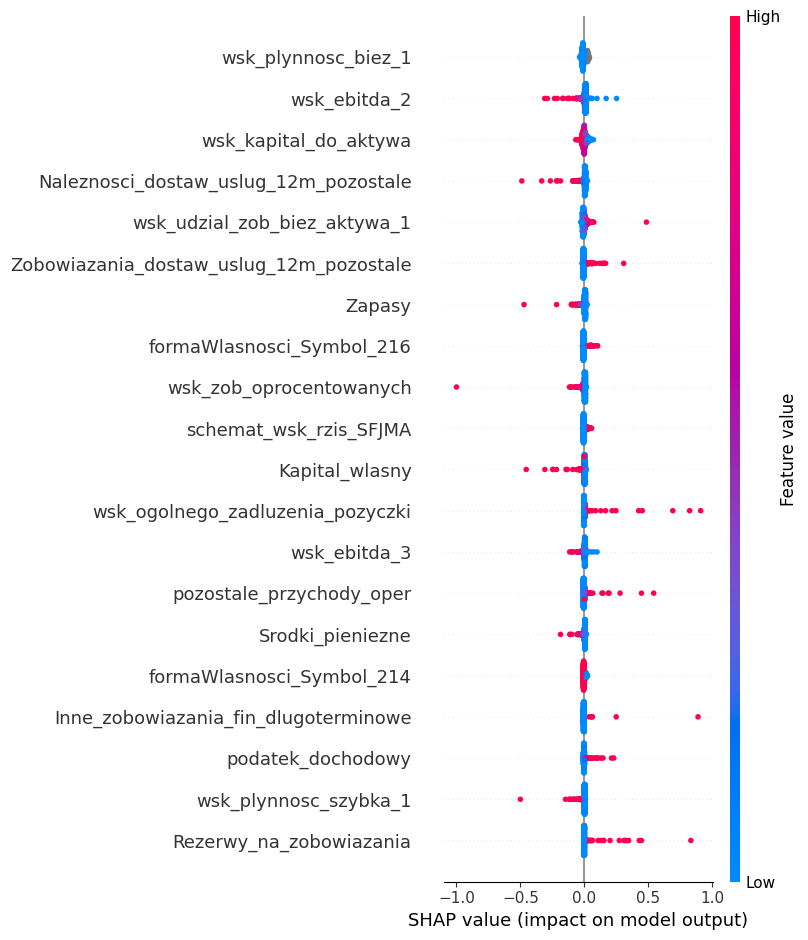

In [19]:
# global summary plot
shap.summary_plot(shap_values.values, X_test)

# `Interpretacja wykresu SHAP`


* SHAP > 0 – zmienna zwiększa ryzyko niespłaty  
* SHAP < 0 – zmienna zmniejsza ryzyko niespłaty 

* Obserwacje blisko zera
- Wiele punktów ma SHAP ≈ 0 czyli cecha nie ma istotnego wpływu na wynik dla wielu firm.  
- Model opiera się głównie na zmiennych o bardzo wysokich wartościach na tle całego zbioru.

## `Wykresy SHAP dla przypadków granicznych`

Ten fragment kodu generuje wykresy waterfall SHAP dla czterech typów przypadków granicznych w zbiorze testowym.

---

### **Działanie kluczowe**

- Funkcja `plot_case(case_idx, title)` wyświetla waterfall plot SHAP dla wskazanego przypadku.  
- Pozwala to szczegółowo analizować, które cechy i w jaki sposób wpływały na konkretne predykcje modelu.

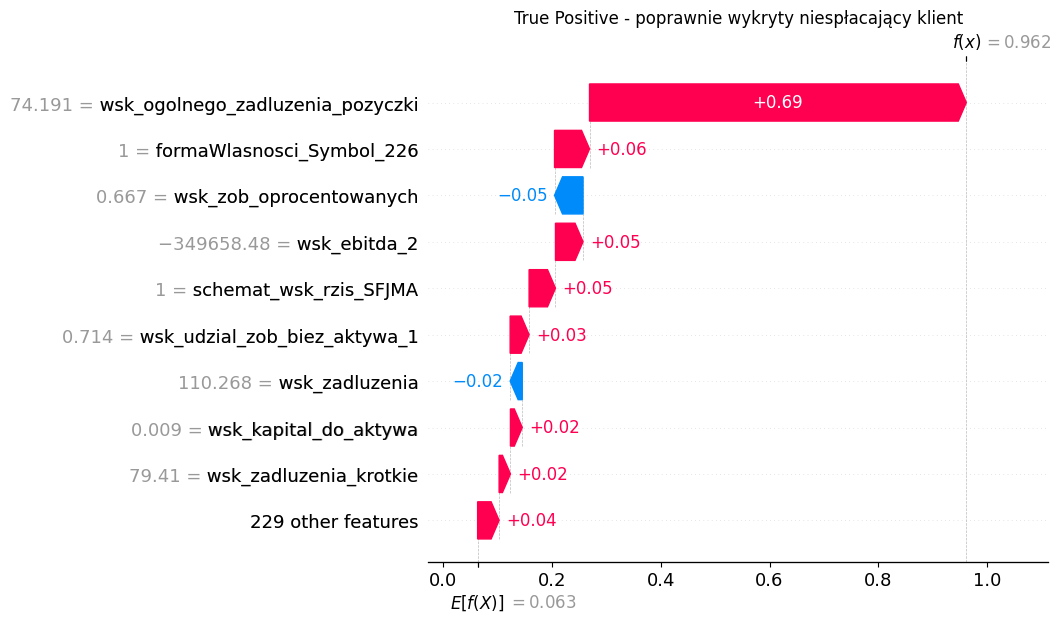

In [20]:
# 4 graniczne case studies
plot_case(tp_idx, "True Positive - poprawnie wykryty niespłacający klient")

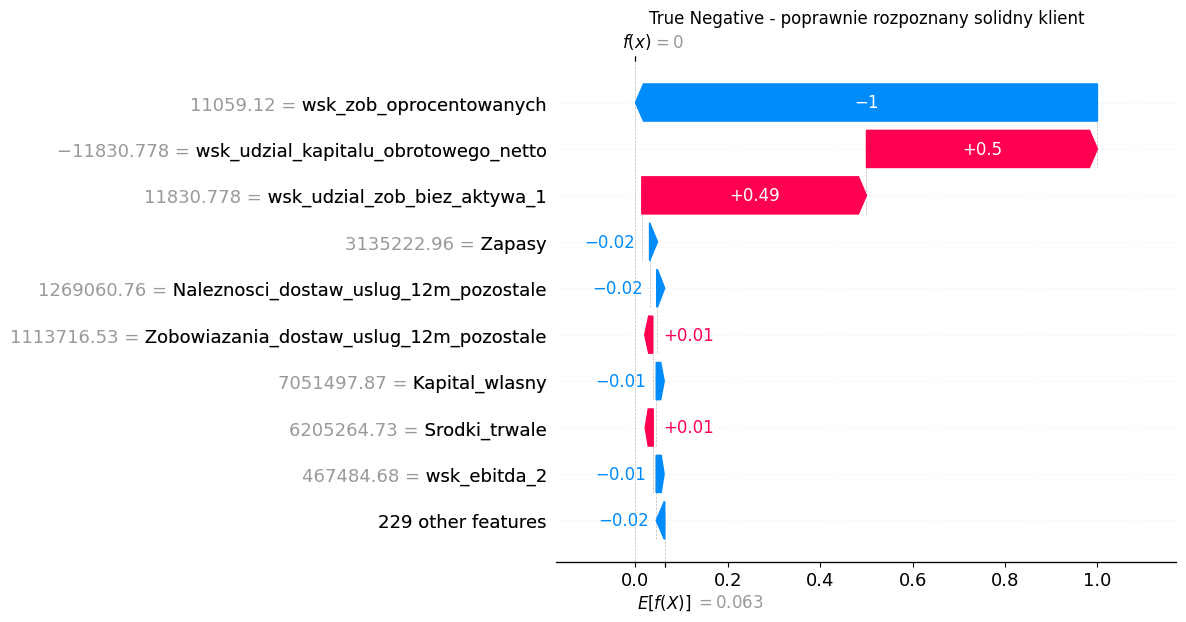

In [21]:
plot_case(tn_idx, "True Negative - poprawnie rozpoznany solidny klient")

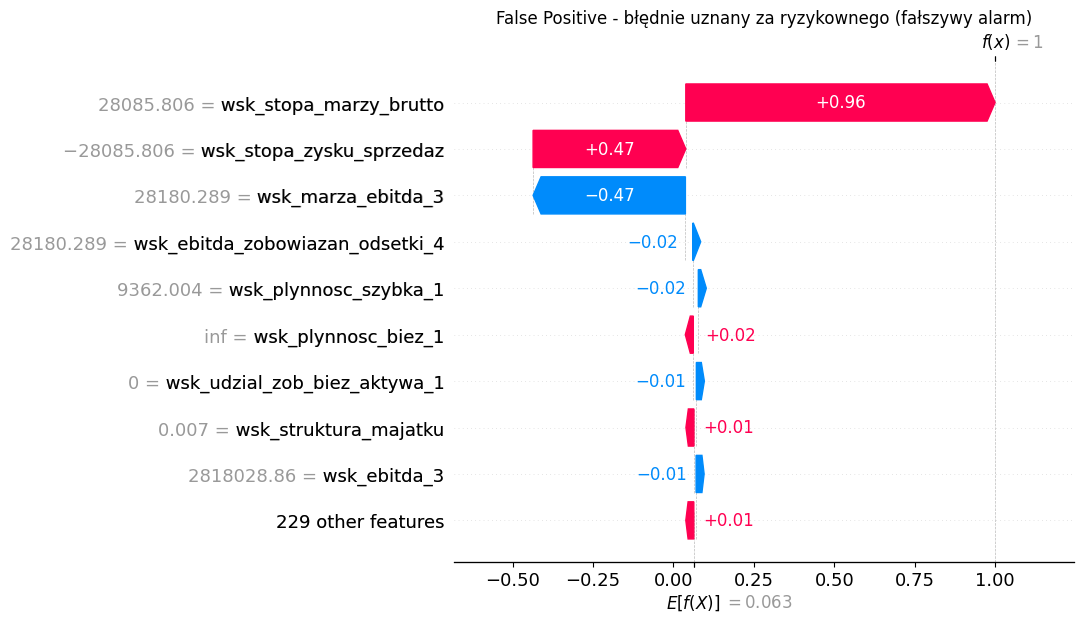

In [22]:
plot_case(fp_idx, "False Positive - błędnie uznany za ryzykownego (fałszywy alarm)")

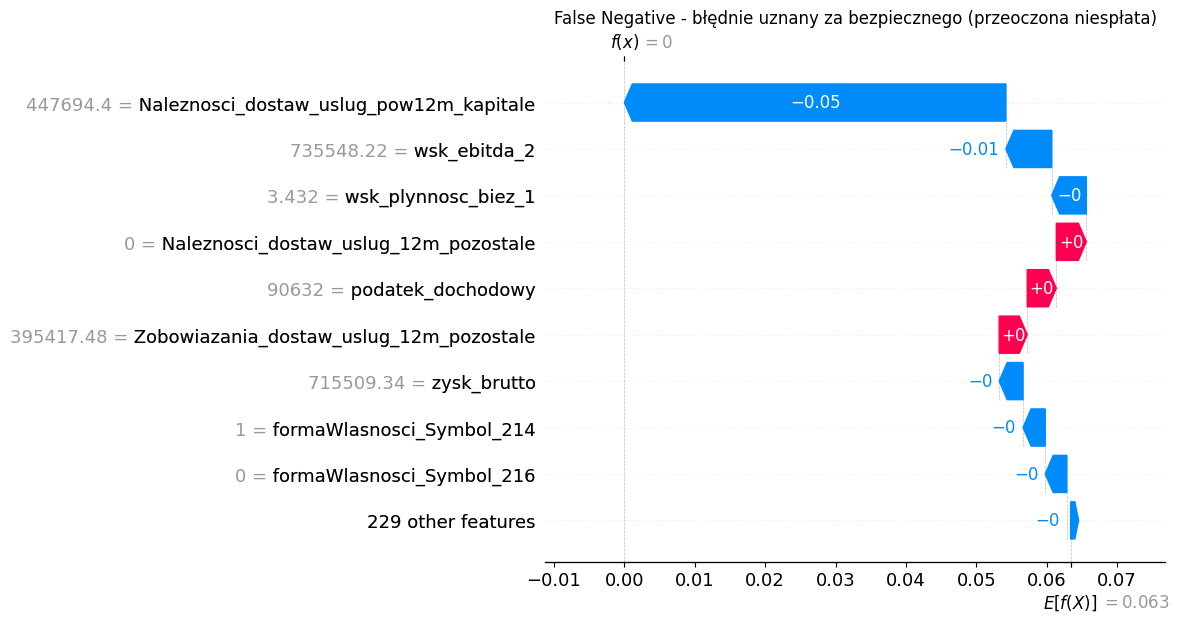

In [23]:
plot_case(fn_idx, "False Negative - błędnie uznany za bezpiecznego (przeoczona niespłata)")

## `Diagnostyka modelu – pre-calibration`

Ten fragment kodu służy do oceny jakości kalibracji predykcji modelu oraz wizualizacji dystrybucji prognozowanych prawdopodobieństw.

---

### **Działanie kluczowe**

1. **Krzywa reliability (calibration curve)**  
   - `calibration_curve` dzieli prognozy na `n_bins=10` przedziałów i porównuje średnie przewidywane prawdopodobieństwa z rzeczywistymi wartościami.  
   - Wykres pokazuje odchylenia modelu od idealnej kalibracji.

2. **Histogram predykcji**  
   - Wizualizacja rozkładu prognozowanych prawdopodobieństw (PD) w zbiorze testowym.

3. **Miary kalibracji i rozdzielczości**  
   - `calibration` – kwadratowe różnice między średnim PD w binach a przewidywaniami.  
   - `resolution` –  wariancja średnich predykcji w binach (względem ogólnej częstości zdarzeń)
   - `brier_score_loss` – średni kwadrat różnicy między przewidywanym prawdopodobieństwem a rzeczywistym wynikiem

4. **Expected Calibration Error (ECE)**  
   - Średnia ważona bezwzględnych różnic między prognozami a rzeczywistym PD w każdym binie.

5. **Adaptive Calibration Error (ACE)**  
   - Kalibracja adaptacyjna, która tworzy biny o równej liczności obserwacji zamiast równych przedziałów prawdopodobieństwa, dzięki czemu lepiej ocenia kalibrację przy nierównomiernym rozkładzie predykcji.

- Wszystkie te wskaźniki pozwalają ocenić, jak dobrze model prognozuje prawdopodobieństwa i czy wymaga kalibracji.

c:\Users\misie\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


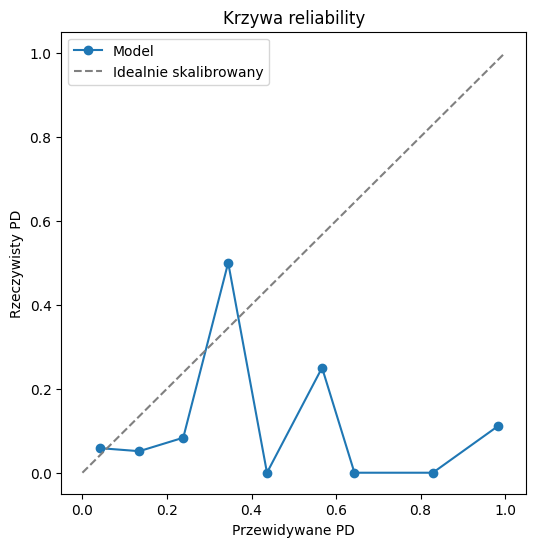

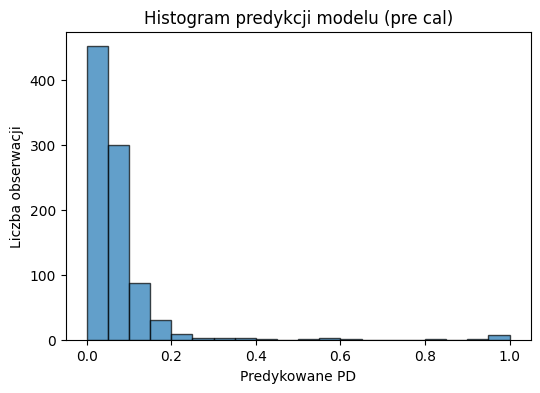

Brier score: 0.0665
Calibration: 0.0111
Resolution: 0.0011
ECE: 0.0410
ACE: 0.5771


In [24]:
# diagnostyka pre-cal
X_test_df = pd.DataFrame(X_test, columns=X_train.columns)
y_prob = best_model.predict_proba(X_test_df)[:, 1]


# Krzywa reliability
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0,1],[0,1], linestyle='--', color='gray', label='Idealnie skalibrowany')
plt.xlabel("Przewidywane PD")
plt.ylabel("Rzeczywisty PD")
plt.title("Krzywa reliability")
plt.legend()
plt.show()

# Histogram predykcji
plt.figure(figsize=(6,4))
plt.hist(y_prob, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel("Predykowane PD")
plt.ylabel("Liczba obserwacji")
plt.title("Histogram predykcji modelu (pre cal)")
plt.show()

bin_edges = np.linspace(0, 1, 11)
bin_indices = np.digitize(y_prob, bins=bin_edges, right=True)

p_mean = np.mean(y_test)
calibration = 0.0
resolution = 0.0

for i in range(len(bin_edges)-1):
    mask = bin_indices == (i+1)
    n_bin = np.sum(mask)
    if n_bin == 0:
        continue
    p_bin = np.mean(y_test[mask])
    p_pred_bin = np.mean(y_prob[mask])
    calibration += n_bin * (p_bin - p_pred_bin)**2
    resolution += n_bin * (p_bin - p_mean)**2

calibration /= len(y_prob)
resolution /= len(y_prob)

brier = brier_score_loss(y_test, y_prob)
print(f"Brier score: {brier:.4f}")
print(f"Calibration: {calibration:.4f}")
print(f"Resolution: {resolution:.4f}")

# ECE (Expected Calibration Error)
ece = 0.0
for i in range(1, len(bin_edges)):
    mask = bin_indices == i
    if np.sum(mask) == 0:
        continue
    p_bin = np.mean(y_test[mask])
    p_pred_bin = np.mean(y_prob[mask])
    ece += (np.sum(mask)/len(y_prob)) * abs(p_bin - p_pred_bin)
print(f"ECE: {ece:.4f}")

# ACE (Adaptive Calibration Error)
ace = 0.0
total_weight = 0.0
for i in range(1, len(bin_edges)):
    mask = bin_indices == i
    n_bin = np.sum(mask)
    if n_bin == 0:
        continue
    weight = 1 / n_bin
    p_bin = np.mean(y_test[mask])
    p_pred_bin = np.mean(y_prob[mask])
    ace += weight * abs(p_bin - p_pred_bin)
    total_weight += weight
ace /= total_weight
print(f"ACE: {ace:.4f}")

# `Diagnostyka pre-cal`

* Krzywa reliability
    - Na wykresie linia modelu leży wyraźnie poniżej linii idealnej kalibracji. Oznacza to, że model zaniża rzeczywiste prawdopodobieństwo – szczególnie w wyższych przedziałach przewidywań. Sygnalizuje to potrzebę późniejszej kalibracji, ale nie jest to sytuacja nietypowa dla modeli pre-cal.


* Brier score i jego dekompozycja
    - Brier score: 0.0665 – wynik, wskazujący, że błędy probabilistyczne są znaczące
    - Kalibracja: 0.0111 – główny składnik błędu; pokazuje, że największą część niedokładności stanowi właśnie niedopasowanie między przewidywanymi a faktycznymi PD  
    - Rozdzielczość: 0.0011 – bardzo niska, co sugeruje, że model ekstremalnie słabo różnicuje grupy ryzyka

* ECE i ACE
    - ECE: 0.0410
    - ACE: 0.5771

Obie miary wskazują na istotny stopień niekalibracji, zwłaszcza dla wyższych prawdopodobieństw. Wyniki sugerują potrzebę kalibracji.

* Histogram predykcji
    - duże nagromadzenie obserwacji przy PD = 0 sugeruje to niedoszacowanie PD oraz ograniczoną zdolność do różnicowania firm o niskim ryzyku
    - histogram potwierdza, że model wymaga kalibracji

* Podsumowanie
Model na etapie diagnostyki „pre-cal” wykazuje:
    - zauważalne niedopasowanie kalibracyjne
    - bardzo niską rozdzielczość
    - histogram potwierdza potrzebę kalibracji
    
Wyniki nie wyglądają najlepiej, ale są spójne z tym, czego można się spodziewać przed  kalibracją.

## `Kalibracja predykcji modelu`

Ten fragment kodu przeprowadza różne metody kalibracji probabilistycznej dla modelu i ocenia ich skuteczność.

---

### **Działanie kluczowe**

1. **Kalibracja metodą Platta (sigmoid) z CV**  
   - `CalibratedClassifierCV(method='sigmoid', cv=5)` dopasowuje funkcję sigmoidalną do surowych predykcji modelu.  
   - `y_cal_platt` – przewidywania skalibrowane tą metodą.

2. **Kalibracja izotoniczna z CV**  
   - `CalibratedClassifierCV(method='isotonic', cv=5)` dopasowuje funkcję izotoniczną do predykcji.  
   - `y_cal_iso` – przewidywania po kalibracji izotonicznej.

3. **Kalibracja Beta**  
   - `BetaCalibration()` dopasowuje parametry Beta do rozkładu surowych predykcji.  
   - `y_cal_beta` – przewidywania po kalibracji beta.

4. **Ocena jakości predykcji**  
   - Funkcja `evaluate` oblicza:  
     - `Brier score` – błąd predykcji probabilistycznej  
     - Średnią PD (średnie przewidywane prawdopodobieństwo).  
   - Ocena wykonywana jest dla surowych i skalibrowanych predykcji.

5. **Krzywa reliability (calibration curve)**  
   - Dla każdej wersji predykcji (raw, Platt, Isotonic, Beta) tworzona jest krzywa pokazująca zależność średnich obserwowanych PD vs. średnich przewidywanych PD w binach.  
   - Linia przerywana `y=x` reprezentuje idealnie skalibrowany model.  
   - Wykres pozwala porównać skuteczność poszczególnych metod kalibracji.

c:\Users\misie\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\misie\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Brier score (surowe PD): 0.0665
Średnia PD (surowe PD): 7.0443%
Brier score (Platt): 0.0575
Średnia PD (Platt): 6.0958%
Brier score (Isotonic): 0.0566
Średnia PD (Isotonic): 6.1582%
Brier score (Beta): 0.0682
Średnia PD (Beta): 6.9634%


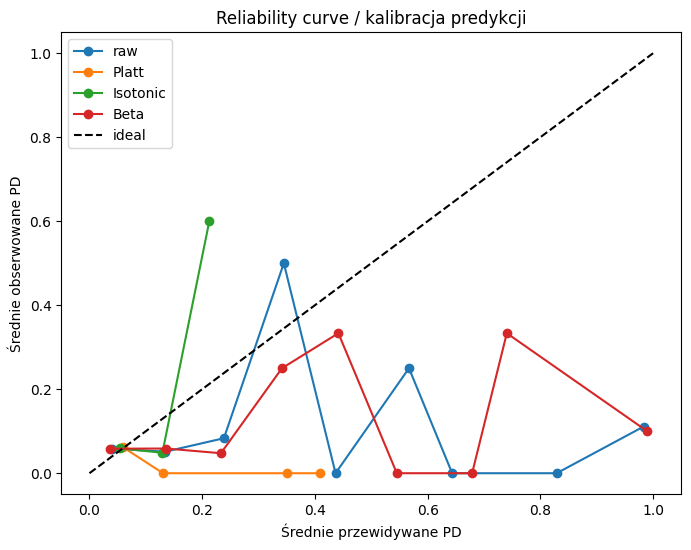

In [25]:

# Surowe predykcje
y_pred_train = best_model.predict_proba(X_train)[:,1]
y_pred_test = best_model.predict_proba(X_test)[:,1]


# Platt calibration z CV

platt_calibrator = CalibratedClassifierCV(estimator=best_model, method='sigmoid', cv=5)
platt_calibrator.fit(X_train, y_train)
y_cal_platt = platt_calibrator.predict_proba(X_test)[:,1]

# Isotonic calibration z CV
iso_calibrator = CalibratedClassifierCV(estimator=best_model, method='isotonic', cv=5)
iso_calibrator.fit(X_train, y_train)
y_cal_iso = iso_calibrator.predict_proba(X_test)[:,1]

# Beta calibration

bc = BetaCalibration()
bc.fit(y_pred_train, y_train)
y_cal_beta = bc.predict(y_pred_test)



# Brier score i średnia PD
def evaluate(y_true, y_pred, label):
    brier = brier_score_loss(y_true, y_pred)
    print(f"Brier score ({label}): {brier:.4f}")
    print(f"Średnia PD ({label}): {np.mean(y_pred):.4%}")

evaluate(y_test, y_pred_test, "surowe PD")
evaluate(y_test, y_cal_platt, "Platt")
evaluate(y_test, y_cal_iso, "Isotonic")
evaluate(y_test, y_cal_beta, "Beta")

# krzywa reliability

plt.figure(figsize=(8,6))
for y_cal, label in zip([y_pred_test, y_cal_platt, y_cal_iso, y_cal_beta],
                        ["raw", "Platt", "Isotonic", "Beta"]):
    prob_true, prob_pred = calibration_curve(y_test, y_cal, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=label)
    
plt.plot([0,1],[0,1], 'k--', label='ideal')
plt.xlabel("Średnie przewidywane PD")
plt.ylabel("Średnie obserwowane PD")
plt.title("Reliability curve / kalibracja predykcji")
plt.legend()
plt.show()

# `Interpreteacja wyników po wstępnej kalibracji`
W ramach analizy wykonano trzy techniki kalibracji prawdopodobieństw: platt, isotonic oraz beta calibration. Surowe PD generowane przez model miały średnią ok. 7.0443%, podczas gdy rzeczywista częstość zdarzeń w danych testowych wynosi ok. 6%. Oznacza to nieznaczne globalne przeszacowanie ryzyka. Najniższy Brier score uzyskała kalibracja izotoniczna (0.0566), co sugeruje, że najlepiej odwzorowała relację pomiędzy przewidywanymi a obserwowanymi PD. Z tego powodu zdecydowano wykorzystać ją do kalibracji do 4%.

## `Isotonic calibration z Calibration-in-the-Large`

Ten fragment kodu przeprowadza globalne skalibrowanie predykcji modelu do docelowego PD i ocenia jakość kalibracji.

---

### **Działanie kluczowe**


1. **Kalibracja izotoniczna**  
   - `CalibratedClassifierCV(method='isotonic', cv=5)` - dopasowuje funkcję izotoniczną do predykcji modelu.  
   - `y_iso_train` i `y_iso_test` – skalibrowane predykcje izotoniczne.

2. **Calibration-in-the-Large**  
   - Globalne przesunięcie średniej PD do wartości docelowej `target_pd = 0.04`.  
   - Iteracyjna korekta w przestrzeni logitowej 
   - `y_iso_global` – predykcje po isotonic + globalnym przesunięciu.

3. **Ocena jakości predykcji**  
   - `brier_score_loss` dla surowych, isotonic i globalnie przesuniętych predykcji.  
   - Funkcja `ECE` – Expected Calibration Error.
   - Obliczenia pokazują, jak kalibracja wpływa na dokładność i zgodność predykcji z rzeczywistym PD.

4. **Krzywa reliability**  
   - Porównanie średnich przewidywanych PD z średnimi obserwowanymi w binach (`calibration_curve`).  
   - Wyświetlane są trzy wyniki:  
     - Raw – surowe predykcje modelu  
     - Isotonic + Global 4% – predykcje po kalibracji izotonicznej i globalnym przesunięciu  
     - Ideal – linia idealnie skalibrowanego modelu (`y=x`).  
   - Krzywa umożliwia wizualną ocenę poprawy kalibracji po zastosowaniu metod isotonic i Calibration-in-the-Large.


Średnia PD po isotonic: 0.06158244967604934
Średnia PD po isotonic + calibration-in-the-large: 0.04000000001076154
Brier raw:      0.06654873412401077
Brier isotonic: 0.05658688979889405
Brier global:   0.05703349161003675
ECE raw:        0.03984804703013596
ECE isotonic:   0.01764042382246533
ECE global:     0.021491786020386212


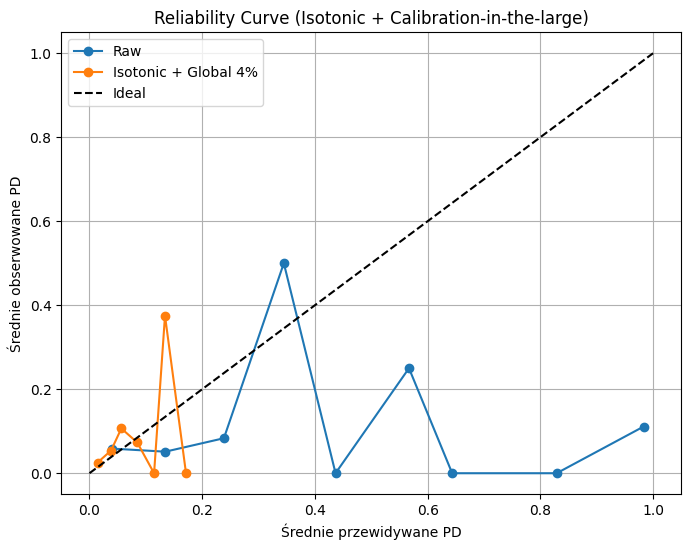

In [26]:
y_pred_train = best_model.predict_proba(X_train)[:, 1]
y_pred_test  = best_model.predict_proba(X_test)[:, 1]

# Isotonic calibration (znowu)
iso_calibrator = CalibratedClassifierCV(estimator=best_model, method='isotonic', cv=5)
iso_calibrator.fit(X_train, y_train)

y_iso_train = iso_calibrator.predict_proba(X_train)[:, 1]
y_iso_test  = iso_calibrator.predict_proba(X_test)[:, 1]

# Calibration-in-the-large do 4%
target_pd = 0.04

y_iso_test_clip = np.clip(y_iso_test, 1e-6, 1 - 1e-6)

y_iso_global = y_iso_test_clip.copy()
for _ in range(5):
    delta = logit(target_pd) - logit(np.mean(y_iso_global))
    y_iso_global = expit(logit(y_iso_global) + delta)

print("Średnia PD po isotonic:", np.mean(y_iso_test))
print("Średnia PD po isotonic + calibration-in-the-large:", np.mean(y_iso_global))


brier_raw      = brier_score_loss(y_test, y_pred_test)
brier_iso      = brier_score_loss(y_test, y_iso_test)
brier_global   = brier_score_loss(y_test, y_iso_global)

print("Brier raw:     ", brier_raw)
print("Brier isotonic:", brier_iso)
print("Brier global:  ", brier_global)

# jak pobralem z ece z jakiejs biblioteki to odinstalowala mi matloptlib XDDDD
def ECE(y_true, y_prob, n_bins=20):
    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        idx = (y_prob >= bins[i]) & (y_prob < bins[i+1])
        if np.sum(idx) > 0:
            bin_true = y_true[idx].mean()
            bin_pred = y_prob[idx].mean()
            ece += (np.sum(idx) / len(y_prob)) * abs(bin_true - bin_pred)
    return ece

ece_raw    = ECE(y_test,   y_pred_test,   n_bins=20)
ece_iso    = ECE(y_test,   y_iso_test,    n_bins=20)
ece_global = ECE(y_test,   y_iso_global,  n_bins=20)

print("ECE raw:       ", ece_raw)
print("ECE isotonic:  ", ece_iso)
print("ECE global:    ", ece_global)

# nowy wykres krzywej reliability
plt.figure(figsize=(8,6))

# surowe PD
prob_true_raw, prob_pred_raw = calibration_curve(y_test, y_pred_test, n_bins=10)
plt.plot(prob_pred_raw, prob_true_raw, "o-", label="Raw")


# Isotonic + global shift
prob_true_glob, prob_pred_glob = calibration_curve(y_test, y_iso_global, n_bins=40)
plt.plot(prob_pred_glob, prob_true_glob, "o-", label="Isotonic + Global 4%")

# Idealna kalibracja
plt.plot([0, 1], [0, 1], "k--", label="Ideal")

plt.xlabel("Średnie przewidywane PD")
plt.ylabel("Średnie obserwowane PD")
plt.title("Reliability Curve (Isotonic + Calibration-in-the-large)")
plt.legend()
plt.grid(True)
plt.show()

## `Histogram predykcji po kalibracji`

Ten fragment kodu wizualizuje rozkład przewidywanych prawdopodobieństw (PD) po zastosowaniu kalibracji isotonicznej i globalnego przesunięcia.

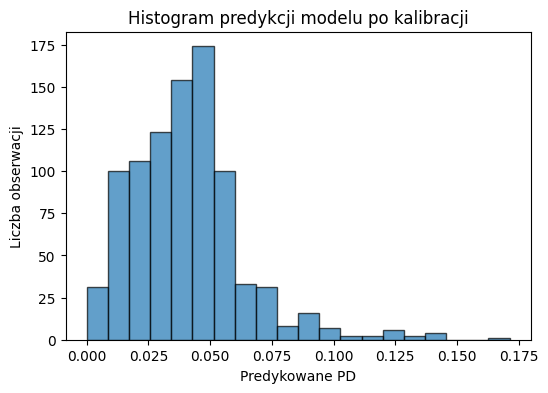

In [27]:
# histogram predykcji  po kalibracji
plt.figure(figsize=(6,4))
plt.hist(y_iso_global, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel("Predykowane PD")
plt.ylabel("Liczba obserwacji")
plt.title("Histogram predykcji modelu po kalibracji")
plt.show()

# `Macierz Kosztów Decyzyjnych`

Ten fragment kodu definiuje macierz kosztów dla problemu klasyfikacji binarnej, przypisuje wagę finansową (lub inną miarę straty) do każdego z czterech możliwych wyników predykcji.

In [28]:
COST_TP = 0.0
COST_FP = 1.0
COST_FN = 16
COST_TN = -1.0

# `Funkcje Optymalizacji Kosztu Decyzyjnego`


Ten blok kodu definiuje dwie funkcje służące do obliczenia całkowitego kosztu podejmowanych decyzji w modelu klasyfikacji w oparciu o zdefiniowaną wcześniej macierz kosztów, a następnie do systematycznego przeszukiwania (sweep) różnych progów decyzyjnych w celu znalezienia progu minimalizującego ten koszt.

In [29]:
def cost_for_threshold(y_true, p, thr):
    yhat = (p >= thr).astype(int)
    
    tp = np.sum((yhat==1) & (y_true==1))
    fp = np.sum((yhat==1) & (y_true==0))
    fn = np.sum((yhat==0) & (y_true==1))
    tn = np.sum((yhat==0) & (y_true==0))
    
    total_cost = tp*COST_TP + fp*COST_FP + fn*COST_FN + tn*COST_TN
    return total_cost, tp, fp, fn, tn

def sweep_costs(y_true, p, n=1001):
    thrs = np.linspace(0,1,n)
    costs, details = [], []
    for t in thrs:
        c, tp, fp, fn, tn = cost_for_threshold(y_true, p, t)
        costs.append(c); details.append((tp,fp,fn,tn))
    return thrs, np.array(costs), details

---
## `Optymalizacja Progu Decyzyjnego w oparciu o Koszty Biznesowe`

---

Poniższy fragment kodu przeprowadza analizę wrażliwości modelu na zmianę progu odcięcia (threshold). Celem jest znalezienie optymalnego punktu pracy, który minimalizuje całkowity koszt finansowy, a nie tylko błąd statystyczny.

Kluczowe kroki analizy:
1.  Sweep (Przeszukiwanie): Obliczenie kosztów dla 201 różnych progów (od 0 do 1).
2.  Optymalizacja: Wybór progu, dla którego funkcja kosztu osiąga minimum:
    $$Cost_{total} = (FP \cdot Cost_{FP}) + (FN \cdot Cost_{FN}) + (TN \cdot Cost_{TN}) + (TP \cdot Cost_{TP})$$
3.  Wizualizacja: Wykres zależności całkowitego kosztu od przyjętego progu decyzyjnego.
4.  Raportowanie: Wyświetlenie szczegółowej macierzy pomyłek oraz stopy akceptacji (Acceptance Rate) dla najlepszego progu.

---

Rozpoczynam analizę zysków i strat dla 900 obserwacji...


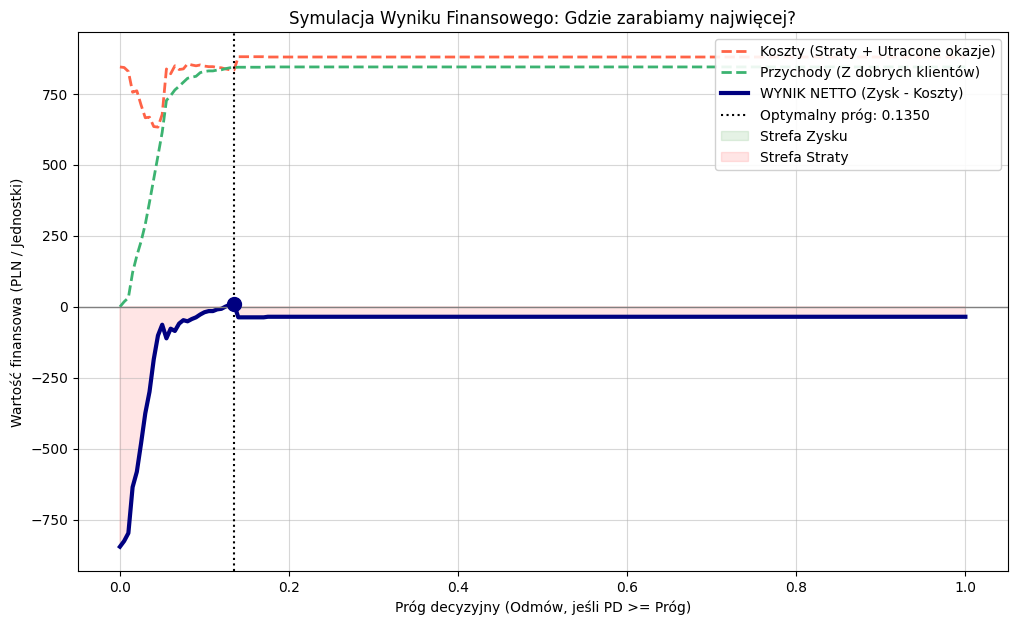


--- WYNIKI SYMULACJI BIZNESOWEJ (Próg: 0.1350) ---
1. Przychody (Revenue):         843.00
2. Koszty (Losses):            -834.00
----------------------------------------
3. ZYSK OPERACYJNY (Profit):    9.00
----------------------------------------
Stopa akceptacji: 99.44%
Macierz pomyłek: TP=3, FP=2, FN=52, TN=843


In [30]:
y_true_data = y_test
p_data = y_iso_global 

print(f"Rozpoczynam analizę zysków i strat dla {len(p_data)} obserwacji...")

thrs, costs, details = sweep_costs(y_true_data, p_data, n=201)

details_arr = np.array(details)
fps_arr = details_arr[:, 1]
fns_arr = details_arr[:, 2]
tns_arr = details_arr[:, 3]
tps_arr = details_arr[:, 0]

revenues_vec = tns_arr * abs(COST_TN)

losses_vec = (fns_arr * COST_FN) + (fps_arr * COST_FP)

net_profit_vec = revenues_vec - losses_vec

max_profit_idx = np.argmax(net_profit_vec) 

best_idx = max_profit_idx 
best_thr_cost = float(thrs[best_idx])
best_cost = costs[best_idx] 

max_profit = net_profit_vec[best_idx]
best_tp, best_fp, best_fn, best_tn = details[best_idx]


# --- RYSOWANIE NOWEGO WYKRESU ---

plt.figure(figsize=(12, 7))

# A. Linia Kosztów (Czerwona)
plt.plot(thrs, losses_vec, color='tomato', linewidth=2, linestyle='--', label='Koszty (Straty + Utracone okazje)')

# B. Linia Przychodów (Zielona)
plt.plot(thrs, revenues_vec, color='mediumseagreen', linewidth=2, linestyle='--', label='Przychody (Z dobrych klientów)')

# C. Linia Zysku Netto (Niebieska)
plt.plot(thrs, net_profit_vec, color='navy', linewidth=3, label='WYNIK NETTO (Zysk - Koszty)')


best_thr = best_thr_cost
plt.axvline(x=best_thr, color='black', linestyle=':', label=f'Optymalny próg: {best_thr:.4f}')
plt.scatter(best_thr, max_profit, color='navy', s=100, zorder=5)

plt.axhline(y=0, color='gray', linewidth=1)

plt.fill_between(thrs, 0, net_profit_vec, where=(net_profit_vec >= 0), color='green', alpha=0.1, label='Strefa Zysku')
plt.fill_between(thrs, 0, net_profit_vec, where=(net_profit_vec < 0), color='red', alpha=0.1, label='Strefa Straty')

plt.title("Symulacja Wyniku Finansowego: Gdzie zarabiamy najwięcej?")
plt.xlabel("Próg decyzyjny (Odmów, jeśli PD >= Próg)")
plt.ylabel("Wartość finansowa (PLN / Jednostki)")
plt.legend(loc='upper right', framealpha=0.9)
plt.grid(True, alpha=0.5)

plt.show()

# --- RAPORT DLA ZARZĄDU ---

opt_loss_val = losses_vec[best_idx]
opt_rev_val = revenues_vec[best_idx]

print(f"\n--- WYNIKI SYMULACJI BIZNESOWEJ (Próg: {best_thr:.4f}) ---")
print(f"1. Przychody (Revenue):         {opt_rev_val:.2f}")
print(f"2. Koszty (Losses):            -{opt_loss_val:.2f}")
print("-" * 40)
print(f"3. ZYSK OPERACYJNY (Profit):    {max_profit:.2f}")
print("-" * 40)

accept_rate = (best_fn + best_tn) / len(y_true_data)
print(f"Stopa akceptacji: {accept_rate:.2%}")
print(f"Macierz pomyłek: TP={best_tp}, FP={best_fp}, FN={best_fn}, TN={best_tn}")

---
## `Segmentacja Ryzyka: Mapowanie PD na Klasy Ratingowe i Walidacja`

---

W tym kroku przekształcamy ciągłe prawdopodobieństwo defaultu (PD) na dyskretne klasy ratingowe (A, B, C), które są zrozumiałe dla biznesu. Następnie przeprowadzamy walidację historyczną (backtesting), aby potwierdzić jakość segmentacji.

Zdefiniowane przedziały (Bins):
* Klasa A (Niskie Ryzyko): $PD \in [0.00, 0.045)$
* Klasa B (Średnie Ryzyko): $PD \in [0.045, 0.15)$
* Klasa C (Wysokie Ryzyko): $PD \in [0.15, 1.00]$

Cele analizy:
1.  Weryfikacja Monotoniczności: Sprawdzenie, czy rzeczywisty odsetek niespłacalności rośnie wraz z pogarszaniem się klasy ratingowej (tj. czy $DefaultRate_A < DefaultRate_B < DefaultRate_C$).
2.  Kalibracja Decyzji: Przypisanie konkretnych działań (np. "Akceptacja Automatyczna", "Analiza Manualna") do każdej klasy w oparciu o rzeczywiste ryzyko.
3.  Wizualizacja: Wykres słupkowy obrazujący jakość separacji ryzyka między klasami.

---

Nowy próg dla Klasy A (PD < ...): 0.0296
Nowy próg dla Klasy B (PD < ...): 0.0476

--- Nowa liczność klientów (Dążymy do rozkładu 25/50/25) ---
col_0                            Liczność klientów
row_0                                             
A (Akceptacja - Niskie Ryzyko)                 297
B (Analiza - Średnie Ryzyko)                   304
C (Odrzucenie - Wysokie Ryzyko)                299

--- Walidacja Monotoniczności Ratingów ---
                                 Liczność  Średnie_Prognozowane_PD  \
Rating                                                               
A (Akceptacja - Niskie Ryzyko)        297                 0.016969   
B (Analiza - Średnie Ryzyko)          304                 0.039127   
C (Odrzucenie - Wysokie Ryzyko)       299                 0.063765   

                                 Rzeczywisty_Odsetek_Default  
Rating                                                        
A (Akceptacja - Niskie Ryzyko)                      0.023569  
B (Analiza - Śred

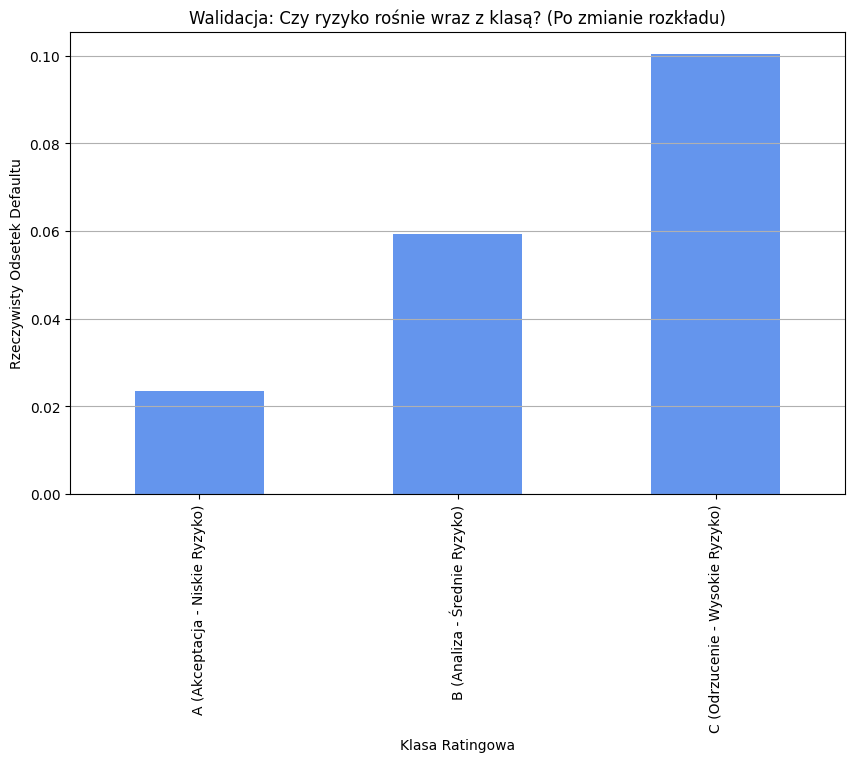

In [31]:
final_pd = y_iso_global

threshold_A = np.quantile(final_pd, 0.33)
threshold_B = np.quantile(final_pd, 0.67)

if threshold_A < 0.0001:
    threshold_A = np.quantile(final_pd, 0.05)

print(f"Nowy próg dla Klasy A (PD < ...): {threshold_A:.4f}")
print(f"Nowy próg dla Klasy B (PD < ...): {threshold_B:.4f}")

rating_bins = [0.00, threshold_A, threshold_B, 1.01]
rating_labels = [
    "A (Akceptacja - Niskie Ryzyko)", 
    "B (Analiza - Średnie Ryzyko)", 
    "C (Odrzucenie - Wysokie Ryzyko)"
]

def pd_to_rating(p, bins, labels):
    return pd.cut(p, bins=bins, labels=labels, right=False, include_lowest=True)

ratings = pd_to_rating(final_pd, rating_bins, rating_labels)

print("\n--- Nowa liczność klientów (Dążymy do rozkładu 25/50/25) ---")
tab_licznosci = pd.crosstab(ratings, columns="Liczność klientów")
print(tab_licznosci)

validation_df = pd.DataFrame({
    'Rating': ratings,
    'Predicted_PD': final_pd,
    'Actual_Default': y_test
})

rating_summary = validation_df.groupby('Rating').agg(
    Liczność=('Rating', 'count'),
    Średnie_Prognozowane_PD=('Predicted_PD', 'mean'),
    Rzeczywisty_Odsetek_Default=('Actual_Default', 'mean')
)

print("\n--- Walidacja Monotoniczności Ratingów ---")
print(rating_summary)

plt.figure(figsize=(10, 6))
rating_summary['Rzeczywisty_Odsetek_Default'].plot(kind='bar', color='cornflowerblue')
plt.title("Walidacja: Czy ryzyko rośnie wraz z klasą? (Po zmianie rozkładu)")
plt.xlabel("Klasa Ratingowa")
plt.ylabel("Rzeczywisty Odsetek Defaultu")
plt.grid(axis='y')
plt.show()